<a href="https://colab.research.google.com/github/caroldaza/DM_CyT/blob/main/EEG_microstates_v3_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib.gridspec as gridspec
import scipy
from scipy.signal import butter, lfilter
import scipy.spatial.distance as d
from sklearn import decomposition
import seaborn as sns; sns.set_theme()
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
import pylab
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
import random

In [4]:
!pip install mne
import mne

     |████████████████████████████████| 6.9 MB 6.3 MB/s 


(0) Levanto datos de EEG

El registro de EEG de 30 canales viene en formato txt. La frecuencia de muestreo es de 128 Hz.

Los datos ya vienen limpios y filtrados entre 2 y 20 Hz

In [5]:
# Montage 10-20
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Elijo canales que tengo
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_30 = mont1020.copy()
# Me quedo solo con los canales seleccionados
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Me quedo con las referencias desde dónde están ubicados los canales
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=128,
                            ch_types='eeg').set_montage(mont1020_30)

(1) Inspección de los datos

(1.1) Topografía media

(1.2) Descomposición (PCA-1)

(2) Cálculo del Global Field Power

In [6]:
subject = [8,9,10,12,13] 
periodo = [1,2]
srate=128

EEGdata_all = pd.DataFrame()

i=0
for ind,sub in enumerate(subject):
  for per in range(1,3):
    
    filename = '/content/drive/MyDrive/procesados/suj_' + str(sub) + '_bl_' + str(per) + '.txt'

    datos = pd.read_csv(filename, sep=',', header=None)
    EEGdata = datos.to_numpy()

    globals()['df' + str(i)] = EEGdata # esto crea variables df y les asigna dataframes que va leyendo
    i += 1

# pasar numpy array a dataset
# seguro hay una manera mas inteligente de escribir esto pero para rapidez
df0 = pd.DataFrame(df0) #s8 p1
df1 = pd.DataFrame(df1) #s8 p2
df2 = pd.DataFrame(df2) #s9 p1
df3 = pd.DataFrame(df3) #s9 p2
df4 = pd.DataFrame(df4) #s10 p1
df5 = pd.DataFrame(df5) #s10 p2
df6 = pd.DataFrame(df6) #s12 p1
df7 = pd.DataFrame(df7) #s12 p2
df8 = pd.DataFrame(df8) #s13 p1
df9 = pd.DataFrame(df9) #s13 p2

# Concateno pre y post por sujeto

frames1 = [df0,df1]  
frames2 = [df2,df3]
frames3 = [df4,df5]
frames4 = [df6,df7]
frames5 = [df8,df9]

# No calculo el GFP aqui porque voy a sacar todo de la funcion kmeans

# Concatenando todo para hacer matrices grandes

Todo_EEG_p=pd.concat([df0,df1,df2,df3,df4,df5,df6,df7,df8,df9],axis=1) # Todas los EEG juntos version pandas
Todo_EEG = Todo_EEG_p.to_numpy() # Todos los EEG juntos version numpy array

In [7]:
# Uso la matriz escaleada de aqui en adelante
Todo_EEG_scaled = StandardScaler().fit_transform(Todo_EEG)

In [8]:
Todo_EEG_scaled.shape[0],Todo_EEG_scaled.shape[1]

(30, 76810)

# (3) Clusterización



Previo, uso la parte de gfp de la funcion kmeans de clase para calcular la matriz de EEG en los picos de GFP


In [9]:
# k means modificado funcion
# la diferencia de esta funcion con kmeans3 es que en esta los picos de gfp se calculan adentro y en la kmeans3 se ponen como parametro

def locmax(x):
    dx = np.diff(x) # discrete 1st derivative
    zc = np.diff(np.sign(dx)) # zero-crossings of dx
    m = 1 + np.where(zc == -2)[0] # indices of local max.
    return m

def GFP(dat): 

    data=dat.transpose()
    n_t = data.shape[0]
    n_ch = data.shape[1]
    data = data - data.mean(axis=1, keepdims=True)

    # GFP peaks
    gfp = np.std(data, axis=1)
    gfp_peaks = locmax(gfp)
    gfp_values = gfp[gfp_peaks]

    return gfp_peaks

In [10]:
# Calculando la matriz de EEG en los picos de GFP
gfp_peaks = GFP(Todo_EEG_scaled)

In [11]:
len(gfp_peaks)

10298

In [12]:
# recuperando los valores de EEG en los picos
EEG_todo_scaled = Todo_EEG_scaled[:,gfp_peaks] 
EEG_todo_scaled_p = pd.DataFrame(EEG_todo_scaled) # version pandas

## (3.1) Tendencia al clustering

Para detectar la tendencia al clustering se calcula el estadistico de Hopkins:

In [13]:
datos = EEG_todo_scaled.transpose()

d = datos.shape[1] # columnas (esta al contrario por el transpose)
n = datos.shape[0] # filas
m = 1000 # cantidad de puntos al azar

nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(datos) # buscador de vecinos

rand_ind = random.sample(range(0, n, 1), m) # indices al azar

ui = []
wi = []
for j in range(0, m):
    u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True) # distancia a los nuevos puntos
    ui.append(u_dist[0][1])
    w_dist, _ = nbrs.kneighbors(datos[rand_ind[j]].reshape(1, -1), 2, return_distance=True) # distancia a los puntos al azar
    wi.append(w_dist[0][1])

H = sum(wi) / (sum(ui) + sum(wi))
H

0.35797552596160237

Un coeficiente de Hopkins menor que 0,5 quiere decir que los puntos estan menos agrupados que los que se tiran al azar. Sin embargo vamos a intentar clusterizar (da mejor con la matriz sin estandarizar...)

In [14]:
EEG_todo_scaled.shape[0],EEG_todo_scaled.shape[1]

(30, 10298)

## (3.2) Dendrograma

### Distancia Euclidiana

In [15]:
data = EEG_todo_scaled_p.sample(frac=1).reset_index(drop=True) # aleatorizando, frac es la proporcion de filas que devuelve

df = np.transpose(data) # para que clusterize columnas no filas (los puntos en el espacio son las columnas de EEG)

z = linkage(df, method='average', metric='euclidean')


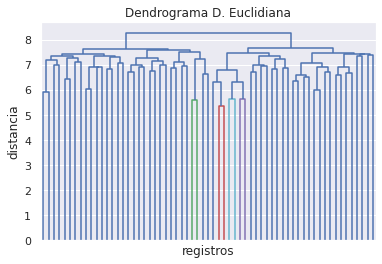

In [16]:
plt.figure()
plt.title('Dendrograma D. Euclidiana')#, ccc = %0.2f'%c)
plt.xlabel('registros')
plt.ylabel('distancia')
dn = dendrogram(z,no_labels=True, p=5, truncate_mode='level')  # show only the last p merged clusters

### Distancia Coseno

In [17]:
data = EEG_todo_scaled_p.sample(frac=1).reset_index(drop=True) # aleatorizando, frac es la proporcion de filas que devuelve

df = np.transpose(data) # para que clusterize columnas no filas (los puntos en el espacio son las columnas de EEG)

z_cosine = linkage(df, method='average', metric='cosine')

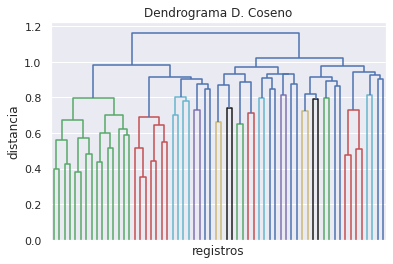

In [18]:
plt.figure()
plt.title('Dendrograma D. Coseno')#, ccc = %0.2f'%c)
plt.xlabel('registros')
plt.ylabel('distancia')
dn = dendrogram(z_cosine,no_labels=True, p=5, truncate_mode='level')  # show only the last p merged clusters

### Correlacion

Matriz de distancias tomando la correlacion:

In [19]:
z_correlation = linkage(df, method='average', metric='correlation')

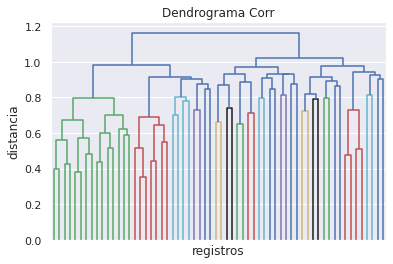

In [20]:
plt.figure()
plt.title('Dendrograma Corr')#, ccc = %0.2f'%c)
plt.xlabel('registros')
plt.ylabel('distancia')
dn = dendrogram(z_correlation,no_labels=True, p=5, truncate_mode='level')  # show only the last p merged clusters

In [21]:
# Cortando por ejemplo en 5 clusters, estos son las etiquetas
numclust = 5

labels_ini_eucl = fcluster(z,numclust,criterion='maxclust') 
labels_ini_cosine = fcluster(z_cosine,numclust,criterion='maxclust') 
labels_ini_corr = fcluster(z_correlation,numclust,criterion='maxclust') 

Matriz de confusión para la clasificación con distancias euclídeas o distancias coseno:

In [22]:
confusion_matrix(labels_ini_eucl, labels_ini_eucl) # para distancia euclidea

array([[4118,    0,    0,    0,    0],
       [   0, 1066,    0,    0,    0],
       [   0,    0,  102,    0,    0],
       [   0,    0,    0,  211,    0],
       [   0,    0,    0,    0, 4801]])

In [23]:
confusion_matrix(labels_ini_cosine, labels_ini_cosine) # para distancia coseno

array([[  40,    0,    0,    0,    0],
       [   0, 3954,    0,    0,    0],
       [   0,    0, 1367,    0,    0],
       [   0,    0,    0,  939,    0],
       [   0,    0,    0,    0, 3998]])

In [24]:
confusion_matrix(labels_ini_corr, labels_ini_corr) # para distancia coseno

array([[  40,    0,    0,    0,    0],
       [   0, 3954,    0,    0,    0],
       [   0,    0, 1367,    0,    0],
       [   0,    0,    0,  939,    0],
       [   0,    0,    0,    0, 3998]])

In [25]:
bin,cuentas = np.unique(labels_ini_corr, return_counts=True)
sum(cuentas)

10298

In [26]:
confusion_matrix(labels_ini_eucl, labels_ini_cosine) # no se que se deduce de esta comparacion Raul

array([[  10,   82,  381,  262, 3383],
       [   3,  204,   96,  470,  293],
       [   2,   15,   31,   19,   35],
       [   0,   67,   35,   64,   45],
       [  25, 3586,  824,  124,  242]])

Se observa una mejora en la clusterizacion usando distancia coseno porque los clusters son mas balanceados (si?). Para la correlacion y la coseno dan igual porque los datos estan estandarizados, entonces no es necesario incluir el calculo de distancia con la correlacion.

## (3.3) K-means modificado

In [27]:
# k means modificado funcion
# la diferencia de esta funcion con kmeans3 es que en esta los picos de gfp se calculan adentro y en la kmeans3 se ponen como parametro

def locmax(x):
    dx = np.diff(x) # discrete 1st derivative
    zc = np.diff(np.sign(dx)) # zero-crossings of dx
    m = 1 + np.where(zc == -2)[0] # indices of local max.
    return m

def kmeans(dat, n_maps, n_runs=10, maxerr=1e-6, maxiter=500): #data[gfp_peaks,:]=gfp_maps.T, gfp[gfp_peaks]=gfp_eval
  # input: datos, numero de clusters, cantidad de corridas, error y número maximo de iteraciones.
  # Output: 
    data=dat.transpose()
    n_t = data.shape[0]
    n_ch = data.shape[1]
    data = data - data.mean(axis=1, keepdims=True)

    # GFP peaks
    gfp = np.std(data, axis=1)
    gfp_peaks = locmax(gfp)
    gfp_values = gfp[gfp_peaks]
    gfp2 = np.sum(gfp_values**2) # normalizing constant in GEV
    n_gfp = gfp_peaks.shape[0]

    # clustering of GFP peak maps only
    V = data[gfp_peaks, :] # maps
    sumV2 = np.sum(V**2)

    # store results for each k-means run
    cv_list =   []  # cross-validation criterion for each k-means run
    gev_list =  []  # GEV of each map for each k-means run
    gevT_list = []  # total GEV values for each k-means run
    maps_list = []  # microstate maps for each k-means run
    L_list =    []  # microstate label sequence for each k-means run
    Llist =    []  # microstate label sequence for each k-means run gfp
    cv_gfp_list = [] # cross-validation criterion for each k-means run para gfp
  
    for run in range(n_runs):
        # initialize random cluster centroids 
        rndi = np.random.permutation(n_gfp)[:n_maps]
        maps = V[rndi, :] #V = data[gfp_peaks, :] 
        # normalize row-wise (across EEG channels)
        maps /= np.sqrt(np.sum(maps**2, axis=1, keepdims=True))
        # initialize
        n_iter = 0
        var0 = 1.0
        var1 = 0.0
        # convergence criterion: variance estimate (step 6)
        while ( (np.abs((var0-var1)/var0) > maxerr) & (n_iter < maxiter) ):
            # (step 3) microstate sequence (= current cluster assignment)
            C = np.dot(V, maps.T)
            C /= (n_ch*np.outer(gfp[gfp_peaks], np.std(maps, axis=1)))
            L = np.argmax(C**2, axis=1)
            # (step 4)
            for k in range(n_maps):
                Vt = V[L==k, :]
                # (step 4a)
                Sk = np.dot(Vt.T, Vt)
                # (step 4b)
                evals, evecs = np.linalg.eig(Sk)
                v = evecs[:, np.argmax(np.abs(evals))]
                v = v.real
                maps[k, :] = v/np.sqrt(np.sum(v**2))
            # (step 5)
            var1 = var0
            var0 = sumV2 - np.sum(np.sum(maps[L, :]*V, axis=1)**2)
            var0 /= (n_gfp*(n_ch-1))
            n_iter += 1
        if (n_iter > maxiter):
          print((f"\tK-means run {run+1:d}/{n_runs:d} did NOT converge "
                   f"after {maxiter:d} iterations."))
            #print((f"\tK-means run {run+1:d}/{n_runs:d} converged after "
            #       f"{n_iter:d} iterations."))
        #else:
        #    print((f"\tK-means run {run+1:d}/{n_runs:d} did NOT converge "
        #          f"after {maxiter:d} iterations."))

        # CROSS-VALIDATION criterion for this run (step 8)
        C_ = np.dot(data, maps.T)
        C_ /= (n_ch*np.outer(gfp, np.std(maps, axis=1)))
        L_ = np.argmax(C_**2, axis=1)
        # ¿no tendría que ser v?
        var = np.sum(data**2) - np.sum(np.sum(maps[L_, :]*data, axis=1)**2)
        var /= (n_t*(n_ch-1))
        cv = var * (n_ch-1)**2/(n_ch-n_maps-1.)**2

         # GEV (global explained variance) of cluster k
        gev = np.zeros(n_maps)
        for k in range(n_maps):
            r = L==k
            gev[k] = np.sum(gfp_values[r]**2 * C[r,k]**2)/gfp2
        gev_total = np.sum(gev)
        
        # store
        cv_list.append(cv)
        gev_list.append(gev)
        gevT_list.append(gev_total)
        maps_list.append(maps)
        L_list.append(L_)
        Llist.append(L)

    # select best run. Lo elige en función del validación cruzada
    k_opt = np.argmin(cv_list)
    gev = gev_list[k_opt]
    maps = maps_list[k_opt]
    L_ = L_list[k_opt]
    L  = Llist[k_opt]

    return maps, L_, L, k_opt,gev,gfp_peaks #maps_kmeans,labels_datos,labels_gfp,cv,GEV,picosgfp

In [28]:
import datetime

### n_clusters = 4

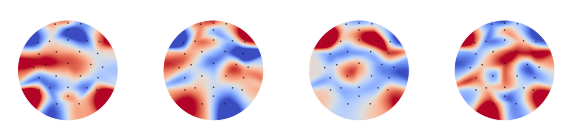

62.31  segundos


In [29]:
# Calculando para 5 clusters como ejemplo y graficando los centroides
st = datetime.datetime.now()
n_clusters = 4

maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG_scaled, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

fig3, ax = plt.subplots(ncols=n_clusters, figsize=(10, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for n in range(n_clusters):
    mne.viz.plot_topomap(maps_kmeans[n,:].T,info_eeg,
                         vmin=-0.3,vmax=0.3, cmap='coolwarm',
                         contours=0, axes=ax[n],show=False)
   # ax[n].set_title('gev='+str(round(100*gev[n],1))+'%', fontweight='bold')
plt.show()
et = datetime.datetime.now()
print(round((et-st).total_seconds(),2)," segundos")

In [30]:
labels_gfp_k_4 = labels_gfp

### n_clusters = 2

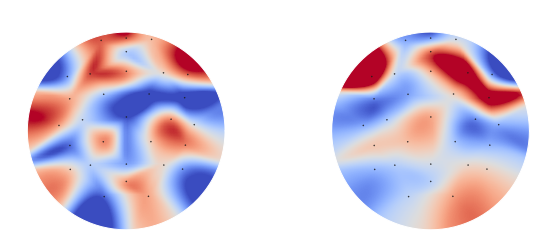

27.0  segundos


In [31]:
# Calculando para 5 clusters como ejemplo y graficando los centroides
st = datetime.datetime.now()
n_clusters = 2

maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG_scaled, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

fig3, ax = plt.subplots(ncols=n_clusters, figsize=(10, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for n in range(n_clusters):
    mne.viz.plot_topomap(maps_kmeans[n,:].T,info_eeg,
                         vmin=-0.3,vmax=0.3, cmap='coolwarm',
                         contours=0, axes=ax[n],show=False)
   # ax[n].set_title('gev='+str(round(100*gev[n],1))+'%', fontweight='bold')
plt.show()
et = datetime.datetime.now()
print(round((et-st).total_seconds(),2)," segundos")

In [32]:
labels_gfp_k_2 = labels_gfp

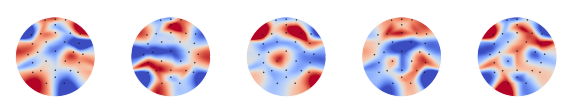

64.14  segundos


In [33]:
# Calculando para 5 clusters como ejemplo y graficando los centroides
st = datetime.datetime.now()
n_clusters = 5

maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG_scaled, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

fig3, ax = plt.subplots(ncols=n_clusters, figsize=(10, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for n in range(n_clusters):
    mne.viz.plot_topomap(maps_kmeans[n,:].T,info_eeg,
                         vmin=-0.3,vmax=0.3, cmap='coolwarm',
                         contours=0, axes=ax[n],show=False)
   # ax[n].set_title('gev='+str(round(100*gev[n],1))+'%', fontweight='bold')
plt.show()
et = datetime.datetime.now()
print(round((et-st).total_seconds(),2)," segundos")

In [34]:
x = round((datetime.datetime.now()-st).total_seconds(), 2)
print(x)

64.15


In [35]:
labels_gfp_k_5 = labels_gfp

In [36]:
# definicion funcion silhoette

def silhoutte_modificado2(maps,data,labels,ch,n_clusters):
    if data.shape[0]!=ch:
       data=data.T
    elif maps.shape[0]!=ch:
       maps=maps.T
    
    corr_ctodos =np.abs(np.corrcoef(data.T))
    sil = []
    for n,i in enumerate(data.T):
        L = labels[n]
        dist = 1-corr_ctodos[n,:]
        dist_=np.delete(dist,n)
        lab_ = np.delete(labels,n)
        prom_dist=[]
        for k in range(n_clusters):
            prom_dist.append(np.mean(dist_[lab_==k]))
        a=prom_dist[L]
        b=np.min(np.delete(prom_dist,L))
        sil.append((b-a)/np.max([a,b]))
    return sil

In [37]:
# Grafico silhoutte
def grafica_sil(n_clusters,sil,labels):
    import matplotlib.cm as cm
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.5, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(labels) + (n_clusters + 1) * 10])

    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = np.mean(sil)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = np.array(sil)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
   # ax1.set_xticks([-1,-0.5,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

Graficando el silhoette para el ejemplo de 5 clusters:

For n_clusters = 5 The average silhouette_score is : 0.1585491882470645


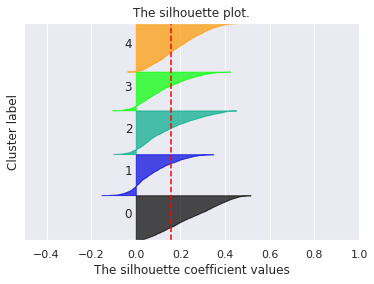

In [38]:
ch    = EEG_todo_scaled.shape[0]
samples = EEG_todo_scaled.shape[1] 

n_clusters = 5

X = EEG_todo_scaled

sil = silhoutte_modificado2(maps_kmeans, X, labels_gfp, ch, n_clusters) # los argumentos se habian calculado arriba para 5 clusters

grafica_sil(n_clusters,sil,labels_gfp)

para un ejemplo de 9 clusters:

For n_clusters = 9 The average silhouette_score is : 0.15727059536103644


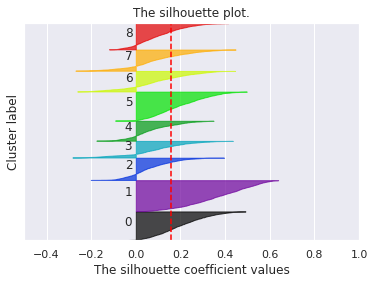

105.83  segundos


In [39]:
st = datetime.datetime.now()

n_clusters = 9

maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG_scaled, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

X = EEG_todo_scaled

sil = silhoutte_modificado2(maps_kmeans, X, labels_gfp, ch, n_clusters)

grafica_sil(n_clusters,sil,labels_gfp)
et = datetime.datetime.now()
print(round((et-st).total_seconds(),2)," segundos")

In [40]:
labels_gfp_k_9 = labels_gfp

Para calcular el numero optimo de clusters se calcula una curva para el Silhoette:

In [41]:
n_clusters =[2,3,4,5,6,7,8,9,10]
cv_nK = np.zeros_like(n_clusters)
sil_nK = []

for n_c in np.arange(len(n_clusters)):
  maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG_scaled, n_clusters[n_c], n_runs=10, maxerr=1e-6, maxiter=500)
  temp = silhoutte_modificado2(maps_kmeans, X,labels_gfp, ch,n_clusters[n_c])
  sil_nK=np.append(sil_nK,np.mean(temp))

In [42]:
# varias corridas
#for n_c in np.arange(len(n_clusters)):
#  for k in range(0,5):
#    maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG_scaled, n_clusters[n_c], n_runs=10, maxerr=1e-6, maxiter=500)
#    temp = silhoutte_modificado2(maps_kmeans, X,labels_gfp, ch,n_clusters[n_c])
#    sil_nK=np.append(sil_nK,np.mean(temp))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


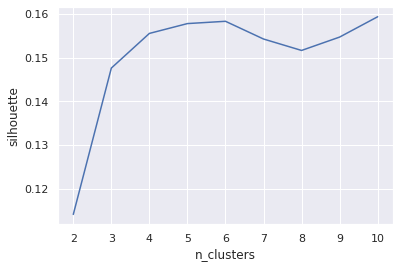

In [43]:
# por ahora subo la grafica sin barritas de error porque se van a demorar
ax = sns.lineplot(n_clusters,sil_nK)
ax.set(xlabel ='n_clusters', ylabel ='silhouette')
plt.show()

### GEV

El grafico de Silhoette se analiza en conjunto con ganancia en varianza explicada y la validacion cruzada:

In [44]:
n_clusters = [2,3,4,5,6,7,8,9,10]
Todo_GEV = []  #curva GEV
Todo_cv = []  # curva cv

for i in range(0,len(n_clusters)):
  maps_kmeans,labels_datos,labels_gfp,cv,GEV,gfp_peaks = kmeans(Todo_EEG_scaled, n_clusters[i], n_runs=100, maxerr=1e-6, maxiter=500)
  Todo_GEV.append(sum(GEV)) 
  Todo_cv.append(cv)

Todo_GEV

[0.3236408469057981,
 0.38273090790753395,
 0.4175021675124457,
 0.442266617661553,
 0.46248792064504796,
 0.47861462034996494,
 0.4917812253340544,
 0.5032600740944039,
 0.5131107018523957]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


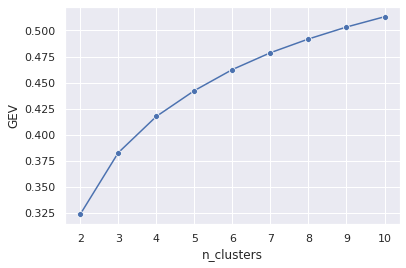

In [45]:
ax = sns.lineplot(n_clusters,Todo_GEV,marker="o")
ax.set(xlabel ='n_clusters', ylabel ='GEV')
plt.show()

### CV

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


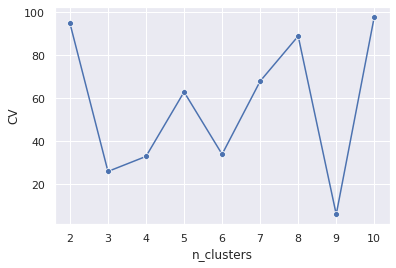

In [46]:
ax = sns.lineplot(n_clusters,Todo_cv,marker="o")
ax.set(xlabel ='n_clusters', ylabel ='CV')
plt.show()

De aca deducimos que 6 clusters es un buen numero para clusterizar los datos, pues a pesar de que hay mas varianza explicada con mas componentes, aumentar una mas, solo incrementa ~0.0125 la varianza explicada. En 6 el cv da minimo, no me acuerdo como explicar el cv.

Calculamos la grafica del silhoette para todos los elementos de cada cluster tomando a 6 como numero de clusters

For n_clusters = 6 The average silhouette_score is : 0.15852759666044688


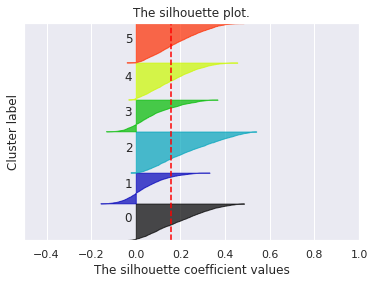

77.88  segundos


In [47]:
st = datetime.datetime.now()

n_clusters = 6

X = EEG_todo_scaled #valores de EEG en los picos

maps_kmeans,labels_datos,labels_gfp,cv,GEV,gfp_peaks = kmeans(Todo_EEG_scaled, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

sil = silhoutte_modificado2(maps_kmeans, X, labels_gfp, ch, n_clusters)
grafica_sil(n_clusters,sil,labels_gfp)
et = datetime.datetime.now()
print(round((et-st).total_seconds(),2)," segundos")

Sacando los outliers presentes:

In [48]:
labels_gfp_k_6 = labels_gfp

In [49]:
sil_pos_ind = [i for i in range(0,len(sil)) if sil[i] > 0] # indices de los silhoette positivos
short_Todo_EEG_scaled = Todo_EEG_scaled[:,sil_pos_ind]

In [50]:
len(sil_pos_ind)

9308

In [51]:
short_Todo_EEG_scaled.shape[0],short_Todo_EEG_scaled.shape[1]

(30, 9308)

In [52]:
Todo_EEG_scaled.shape[0],Todo_EEG_scaled.shape[1]

(30, 76810)

In [53]:
gfp_peaks_new = GFP(short_Todo_EEG_scaled) # gfp nuevos picos

In [54]:
len(gfp_peaks_new)

1225

In [55]:
short_EEG_todo_scaled = short_Todo_EEG_scaled[:,gfp_peaks_new]

In [56]:
short_EEG_todo_scaled.shape[0], short_EEG_todo_scaled.shape[1]

(30, 1225)

In [57]:
EEG_todo_scaled.shape[0],EEG_todo_scaled.shape[1]

(30, 10298)

Volviendo a dibujar los silhoettes para cada elemento en cada cluster:

For n_clusters = 6 The average silhouette_score is : 0.1487398146286719


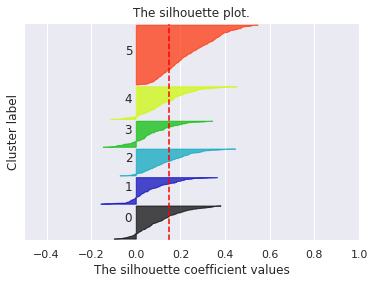

In [58]:
n_clusters = 6

maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(short_Todo_EEG_scaled, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

X = short_EEG_todo_scaled

sil_new = silhoutte_modificado2(maps_kmeans, X, labels_gfp, ch, n_clusters)

grafica_sil(n_clusters,sil_new,labels_gfp)

A pesar de haber sacado los outliers, al clusterizar el metodo detecta mas outliers, lo que concluye que la clusterizacion no se va a ver beneficiada de sacar estos puntos.

Volviendo a recalcular las curvas de Silhoette y GEV:

In [59]:
n_clusters =[2,3,4,5,6,7,8,9,10]
cv_nK_2 = np.zeros_like(n_clusters)
sil_nK_2 = []

X = short_EEG_todo_scaled

for n_c in np.arange(len(n_clusters)):
  maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(short_Todo_EEG_scaled, n_clusters[n_c], n_runs=10, maxerr=1e-6, maxiter=500)
  temp = silhoutte_modificado2(maps_kmeans, X, labels_gfp, ch,n_clusters[n_c])
  sil_nK_2 = np.append(sil_nK_2,np.mean(temp))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


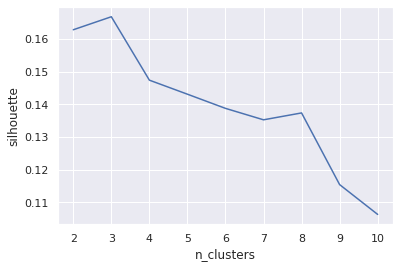

In [60]:
# por ahora subo la grafica sin barritas de error porque se van a demorar
ax = sns.lineplot(n_clusters,sil_nK_2)
ax.set(xlabel ='n_clusters', ylabel ='silhouette')
plt.show()

In [61]:
n_clusters = [2,3,4,5,6,7,8,9,10]
Todo_GEV_new = []  #curva GEV
Todo_cv_new = []  # curva cv

for i in range(0,len(n_clusters)):
  maps_kmeans,labels_datos,labels_gfp,cv,GEV,gfp_peaks = kmeans(short_Todo_EEG_scaled, n_clusters[i], n_runs=100, maxerr=1e-6, maxiter=500)
  Todo_GEV_new.append(sum(GEV)) 
  Todo_cv_new.append(cv)

Todo_GEV_new

[0.37363493975839435,
 0.42276526698196293,
 0.4528824516515353,
 0.475669384925545,
 0.49038210342855376,
 0.5041480208430663,
 0.51812535826803,
 0.5289591705970267,
 0.5357966012122515]

el GEV queda asi:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


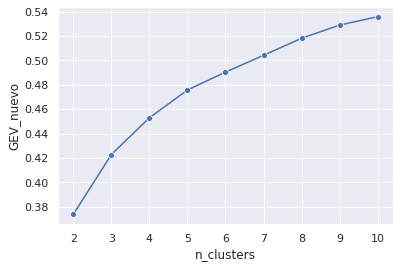

In [62]:
ax = sns.lineplot(n_clusters,Todo_GEV_new,marker="o")
ax.set(xlabel ='n_clusters', ylabel ='GEV_nuevo')
plt.show()

y el cv:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


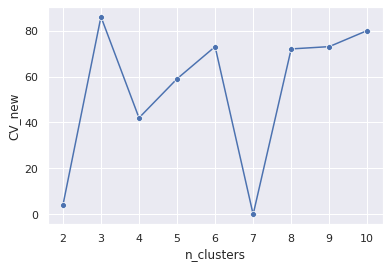

In [63]:
ax = sns.lineplot(n_clusters,Todo_cv_new,marker="o")
ax.set(xlabel ='n_clusters', ylabel ='CV_new')
plt.show()

El GEV se incrementa lo mismo de 6 a 7 clusters pero el cv se dobla. La nueva curva de silhoette da que para este set de datos mas pequeño 5 clusters serian mejor, pero en vista de que las nubes de puntos de silhoette calculadas anteriormente vuelven a mostrar outliers y en mayor cantidad, se concluye que no hay beneficio en sacarlos.

## (3.4) Validacion Externa

### Matriz de confusion

In [64]:
n_clusters = 6   #Todo_EEG matriz completa, EEG_Todo matriz eeg en los picos del gfp

# clusterizacion kmeans
maps_kmeans,labels_datos,labels_gfp,cv,GEV,gfp_peaks= kmeans(Todo_EEG_scaled, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

# ahora las etiquetas del dendrograma
data = EEG_todo_scaled_p.sample(frac=1).reset_index(drop=True) # aleatorizando, frac es la proporcion de filas que devuelve

df = np.transpose(data) # para que clusterize columnas no filas

z = linkage(df, method='average', metric='cosine')


labels_ini_6 = fcluster(z,n_clusters,criterion='maxclust') # los labels clasificando todo el GFP con dendrograma

In [65]:
# la matriz de confusion de comparar el clusterizado de EEG_Todo con dendrograma y con kmeans
tmp = pd.DataFrame({'Labels': labels_ini_6, 'Clusters': labels_gfp})
ct0 = pd.crosstab(tmp['Labels'], tmp['Clusters']) # Create crosstab: ct 
ct0

Clusters,0,1,2,3,4,5
Labels,,,,,,
1,0,1,2,13,16,8
2,784,843,221,958,828,320
3,6,5,10,15,7,8
4,171,59,574,62,128,322
5,69,60,189,294,55,272
6,722,907,503,625,710,531


las que clasifico bien:

In [66]:
ct0_p = ct0
ct0 = ct0_p.to_numpy()
b=ct0.diagonal()
sum(b)

1501

Comparacion con dendrograma distancia euclidea:

In [67]:
# ahora las etiquetas del dendrograma

n_clusters = 6

data = EEG_todo_scaled_p.sample(frac=1).reset_index(drop=True) # aleatorizando, frac es la proporcion de filas que devuelve

df = np.transpose(data) # para que clusterize columnas no filas

z_eu = linkage(df, method='average', metric='euclidean')

labels_ini_6_eu = fcluster(z_eu,n_clusters,criterion='maxclust') # los labels clasificando todo el GFP con dendrograma

In [68]:
# la matriz de confusion de comparar el clusterizado de EEG_Todo con dendrograma y con kmeans
tmp = pd.DataFrame({'Labels': labels_ini_6_eu, 'Clusters': labels_gfp})
ct0_eu = pd.crosstab(tmp['Labels'], tmp['Clusters']) # Create crosstab: ct 
ct0_eu

Clusters,0,1,2,3,4,5
Labels,,,,,,
1,818,897,347,779,749,528
2,136,36,431,184,65,214
3,23,8,9,5,11,20
4,6,3,6,3,1,7
5,18,22,31,24,47,69
6,751,909,675,972,871,623


Las que clasifico bien:

In [69]:
ct0_eu_p = ct0_eu
ct0_eu = ct0_eu_p.to_numpy()
a=ct0_eu.diagonal()
sum(a)


1536

Con la distancia euclidiana, el kmeans clasifica bien 14,27% de los elementos con respecto a la clasificacion del dendrograma. Para la distancia coseno un 12,59%. Le "pega" mal mucha veces, probablemente es el dendrograma el que da una mala clasificacion. Igual habiamos decidido quedarnos con la distancia coseno porque daba clases mas "balanceadas"

### Van Dongen

In [70]:
# cuentita

n2=2*sum(sum(ct0)) # suma de todos los elementos matriz de confusion
sumi = sum(ct0_p.apply(np.max,axis=1))  # suma de los maximos de cada fila
sumj = sum(ct0_p.apply(np.max,axis=0))  # suma de los maximos de cada columna
maxsumi = np.max(ct0_p.apply(sum,axis=1)) #suma de cada fila y selecciona el maximo 
maxsumj = np.max(ct0_p.apply(sum,axis=0)) #suma de cada columna y selecciona el maximo 
vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
vd

0.9056113731118858

La matriz "pura" se diferencia un 90% de la matriz de confusion encontrada (comparacion con el dendrograma metrica coseno)

In [71]:
n2=2*sum(sum(ct0_eu)) # suma de todos los elementos matriz de confusion
sumi = sum(ct0_eu_p.apply(np.max,axis=1))  # suma de los maximos de cada fila
sumj = sum(ct0_eu_p.apply(np.max,axis=0))  # suma de los maximos de cada columna
maxsumi = np.max(ct0_eu_p.apply(sum,axis=1)) #suma de cada fila y selecciona el maximo 
maxsumj = np.max(ct0_eu_p.apply(sum,axis=0)) #suma de cada columna y selecciona el maximo 
vd_eu = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
vd_eu

0.9639137980908302

La matriz "pura" se diferencia un 96% de la matriz de confusion encontrada (comparacion con el dendrograma metrica euclidiana)

Esto quiere decir que las clases no son muy puras, o equivalentemente que no son muy representativas.

### Indice Rand Ajustado

In [72]:
ARI = adjusted_rand_score(labels_ini_6, labels_gfp)
ARI

0.038019052359471846

El indice es muy pequeño. Si las clases estan dadas por el dendrograma, el kmeans las estaria repartiendo mal.

- Realice una inspección de las características de los clusters hallados

### Efecto uniforme (comparando clusters de metodos)
Se puede calcular como el coeficiente de variación (CV = desvío estándar/media) de la distribución del tamaño de las clases. Valores del orden del 85% indica que metodo de clusterizacion esta formando clusters uniformes a pesar de que las clases estan desbalanceadas.

In [73]:
labd,cuentas_d = np.unique(labels_ini_6, return_counts=True)  # cantidad de elementos en cada clase etiquetas dendrograma coseno
labk,cuentas_k = np.unique(labels_gfp, return_counts=True) # cantidad de elementos en cada clase clusterizacion kmeans

cv_dendro = np.std(cuentas_d)/np.mean(cuentas_d)
cv_kmeans = np.std(cuentas_k)/np.mean(cuentas_k)
cv_dendro, cv_kmeans

(0.9679820245246101, 0.10703080676292191)

Segun estos valores, el dendrograma forma clusters uniformes mientras que el kmeans no lo estaria haciendo, por lo que funciona bien

En resumen, todos los metodos que resultan de asumir las clases del dendrograma como las "verdaderas" y comparar con ellas dan mal. Estos resultados se pueden deber a que el dendrograma es malo como metodo de partida. Podriamos usar DBSCAN como metodo para sacar las etiquetas base para comparar a ver si la validacion da mejor.

El analisis de efecto uniforme nos dice que el kmeans no estaria formando clusters uniformes.

- y de los prototipos de cada cluster en caso que los hubiese (o de ejemplos en el caso que no), comparar con los encontrados por el método de k-means modificado.

# Tarea 4

Para los distintos algoritmos, visualizar los datos y las etiquetas de cluster asignadas en
baja dimensión con alguna técnica de reducción (PCA, TSNE, MDS, etc). Esto se puede
repetir para alguna variación que encuentren interesante, como para distintos valores de k o
distintas nociones de distancia.

@Raulgalindez l, como venis con el PCA/TSNE? si te complicas mucho o vienes atrasado, largá PCA para los vectores del la matriz EEG[picos]  (EEG_todo_scaled) y colorea unas cuantas graficas segun las etiqueta con que quede cada elemento tomando distintos ks en kmeans (las etiquetas son las labels_gfp que manda la funcion kmeans)

## PCA

In [74]:
!pip install minisom
!pip install umap-learn

  Created wheel for minisom: filename=MiniSom-2.2.9-py3-none-any.whl size=8594 sha256=b73b141207f066c01d83518322b49a244a7dd88a80b4c6df11a40c3b7069a43a
  Stored in directory: /root/.cache/pip/wheels/3d/a1/10/f50b6f4865652eac239a2700de411c3078c27e1318320e494c
Successfully built minisom
     |████████████████████████████████| 80 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 15.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=036eb7a5ae06e2f70661e196863de4ffee58b82fcd26f1489ab2e521dee921e9
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=01fa6d7d233c34971875b118b99fa15af6432be62f1c230a2afa180d56a7aa3d
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [75]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image, YouTubeVideo, HTML

# Números y Datos
import numpy as np
import pandas as pd
import random

# Machine learning
from sklearn.datasets import samples_generator, fetch_openml, load_digits
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#from umap import UMAP
from minisom import MiniSom
from umap import UMAP

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [76]:
Todo_EEG_scaled.shape

(30, 76810)

### Con etiquetas de kmeans (k=2)

PCA
Varianza explicada por componente: [7.53103744e+00 3.91821622e+00 3.39409088e+00 2.06161661e+00
 1.67850558e+00 1.37117842e+00 1.30271202e+00 1.03231617e+00
 8.23774155e-01 6.28454100e-01 6.10564056e-01 5.49970614e-01
 4.93077149e-01 4.61275927e-01 4.40429353e-01 4.12592325e-01
 3.79658540e-01 3.67170428e-01 3.37668980e-01 3.13214832e-01
 2.96195659e-01 2.84406622e-01 2.58470764e-01 2.30526890e-01
 2.15858167e-01 1.84397563e-01 1.66560584e-01 1.45023255e-01
 1.12032776e-01 1.22039355e-31]


Text(0.5, 1.0, 'Variabilidad explicada: 38.0%')

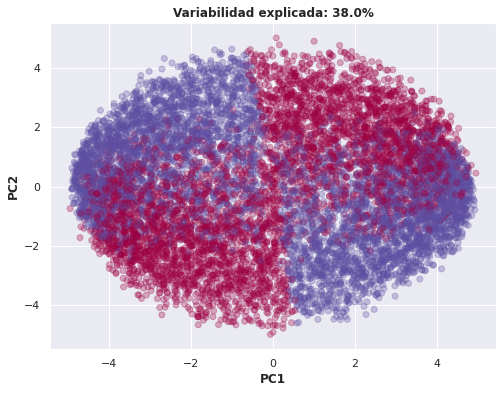

In [83]:
pca = PCA()
Y = pca.fit_transform(EEG_todo_scaled.transpose())

#plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap = plt.cm.Spectral)

#fig = plt.figure(figsize=(32,16))
#ax = fig.add_subplot(251, projection='3d')



plt.scatter(Y[:, 0], Y[:, 1], 
            c=labels_gfp_k_2, 
            cmap = plt.cm.Spectral, alpha = 0.3)
#ax.scatter(Y[:, 1], Y[:, 2], Y[:, 0], c=y, cmap = plt.cm.Spectral)
#ax.view_init(4, -72);
plt.xlabel('PC1',fontweight='bold')
plt.ylabel('PC2',fontweight='bold')

# ax = fig.add_subplot()
print('PCA')
print('Varianza explicada por componente:',pca.explained_variance_)
explained_variance_ratio_ = pca.explained_variance_ / np.sum(pca.explained_variance_)

plt.title("Variabilidad explicada: "+ str(round((explained_variance_ratio_[0] + explained_variance_ratio_[1]),2)*100)+'%',fontweight='bold')


### Con etiquetas de kmeans (k=4)

PCA
Varianza explicada por componente: [7.53103744e+00 3.91821622e+00 3.39409088e+00 2.06161661e+00
 1.67850558e+00 1.37117842e+00 1.30271202e+00 1.03231617e+00
 8.23774155e-01 6.28454100e-01 6.10564056e-01 5.49970614e-01
 4.93077149e-01 4.61275927e-01 4.40429353e-01 4.12592325e-01
 3.79658540e-01 3.67170428e-01 3.37668980e-01 3.13214832e-01
 2.96195659e-01 2.84406622e-01 2.58470764e-01 2.30526890e-01
 2.15858167e-01 1.84397563e-01 1.66560584e-01 1.45023255e-01
 1.12032776e-01 1.22039355e-31]


Text(0.5, 1.0, 'Variabilidad explicada: 38.0%')

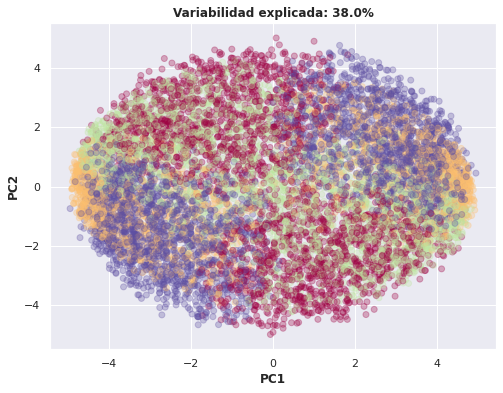

In [78]:
pca = PCA()
Y = pca.fit_transform(EEG_todo_scaled.transpose())

#plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap = plt.cm.Spectral)

#fig = plt.figure(figsize=(32,16))
#ax = fig.add_subplot(251, projection='3d')
plt.scatter(Y[:, 0], Y[:, 1], 
            c=labels_gfp_k_4, 
            cmap = plt.cm.Spectral, alpha = 0.3)
#ax.scatter(Y[:, 1], Y[:, 2], Y[:, 0], c=y, cmap = plt.cm.Spectral)
#ax.view_init(4, -72);
plt.xlabel('PC1',fontweight='bold')
plt.ylabel('PC2',fontweight='bold')

print('PCA')
print('Varianza explicada por componente:',pca.explained_variance_)
explained_variance_ratio_ = pca.explained_variance_ / np.sum(pca.explained_variance_)
# explained_variance_ratio_
plt.title("Variabilidad explicada: "+ str(round((explained_variance_ratio_[0] + explained_variance_ratio_[1]),2)*100)+'%',fontweight='bold') # 

### Con etiquetas de kmeans (k=5)

PCA
Varianza explicada por componente: [7.53103744e+00 3.91821622e+00 3.39409088e+00 2.06161661e+00
 1.67850558e+00 1.37117842e+00 1.30271202e+00 1.03231617e+00
 8.23774155e-01 6.28454100e-01 6.10564056e-01 5.49970614e-01
 4.93077149e-01 4.61275927e-01 4.40429353e-01 4.12592325e-01
 3.79658540e-01 3.67170428e-01 3.37668980e-01 3.13214832e-01
 2.96195659e-01 2.84406622e-01 2.58470764e-01 2.30526890e-01
 2.15858167e-01 1.84397563e-01 1.66560584e-01 1.45023255e-01
 1.12032776e-01 1.22039355e-31]


Text(0.5, 1.0, 'Variabilidad explicada: 38.0%')

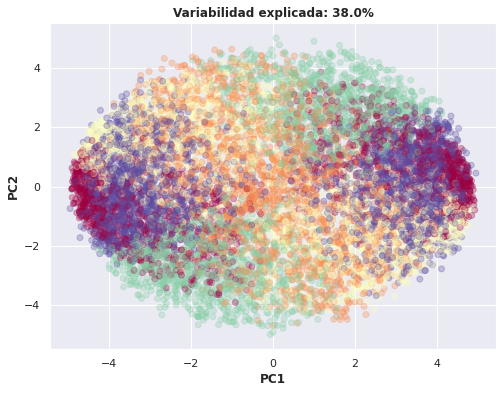

In [79]:
pca = PCA()
Y = pca.fit_transform(EEG_todo_scaled.transpose())

#plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap = plt.cm.Spectral)

#fig = plt.figure(figsize=(32,16))
#ax = fig.add_subplot(251, projection='3d')
plt.scatter(Y[:, 0], Y[:, 1], 
            c=labels_gfp_k_5, 
            cmap = plt.cm.Spectral, alpha = 0.3)
#ax.scatter(Y[:, 1], Y[:, 2], Y[:, 0], c=y, cmap = plt.cm.Spectral)
#ax.view_init(4, -72);

plt.xlabel('PC1',fontweight='bold')
plt.ylabel('PC2',fontweight='bold')

print('PCA')
print('Varianza explicada por componente:',pca.explained_variance_)
explained_variance_ratio_ = pca.explained_variance_ / np.sum(pca.explained_variance_)
explained_variance_ratio_
plt.title("Variabilidad explicada: "+ str(round((explained_variance_ratio_[0] + explained_variance_ratio_[1]),2)*100)+'%',fontweight='bold')

### Con etiquetas de kmeans (k=6)

PCA
Varianza explicada por componente: [7.53103744e+00 3.91821622e+00 3.39409088e+00 2.06161661e+00
 1.67850558e+00 1.37117842e+00 1.30271202e+00 1.03231617e+00
 8.23774155e-01 6.28454100e-01 6.10564056e-01 5.49970614e-01
 4.93077149e-01 4.61275927e-01 4.40429353e-01 4.12592325e-01
 3.79658540e-01 3.67170428e-01 3.37668980e-01 3.13214832e-01
 2.96195659e-01 2.84406622e-01 2.58470764e-01 2.30526890e-01
 2.15858167e-01 1.84397563e-01 1.66560584e-01 1.45023255e-01
 1.12032776e-01 1.22039355e-31]
Varianza explicada por componente: [2.51026247e-01 1.30602871e-01 1.13132606e-01 6.87182719e-02
 5.59483282e-02 4.57044297e-02 4.34222924e-02 3.44093966e-02
 2.74582268e-02 2.09477745e-02 2.03514595e-02 1.83317451e-02
 1.64353593e-02 1.53753537e-02 1.46804910e-02 1.37526209e-02
 1.26548645e-02 1.22386079e-02 1.12552589e-02 1.04401478e-02
 9.87286083e-03 9.47990596e-03 8.61540609e-03 7.68397454e-03
 7.19503334e-03 6.14638137e-03 5.55183515e-03 4.83394801e-03
 3.73430189e-03 4.06784345e-33]


Text(0.5, 1.0, 'Variabilidad explicada: 38.0%')

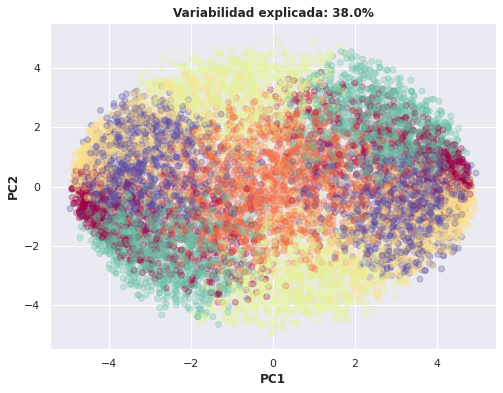

In [80]:
pca = PCA()
Y = pca.fit_transform(EEG_todo_scaled.transpose())

#plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap = plt.cm.Spectral)

#fig = plt.figure(figsize=(32,16))
#ax = fig.add_subplot(251, projection='3d')
plt.scatter(Y[:, 0], Y[:, 1], 
            c=labels_gfp_k_6, 
            cmap = plt.cm.Spectral, alpha = 0.3)
#ax.scatter(Y[:, 1], Y[:, 2], Y[:, 0], c=y, cmap = plt.cm.Spectral)
#ax.view_init(4, -72);

plt.xlabel('PC1',fontweight='bold')
plt.ylabel('PC2',fontweight='bold')


print('PCA')
print('Varianza explicada por componente:',pca.explained_variance_)
explained_variance_ratio_ = pca.explained_variance_ / np.sum(pca.explained_variance_)
print('Varianza explicada por componente:' ,explained_variance_ratio_)
plt.title("Variabilidad explicada: "+ str(round((explained_variance_ratio_[0] + explained_variance_ratio_[1]),2)*100)+'%',fontweight='bold')

### Con etiquetas de kmeans (k=9)

PCA
Varianza explicada por componente: [7.53103744e+00 3.91821622e+00 3.39409088e+00 2.06161661e+00
 1.67850558e+00 1.37117842e+00 1.30271202e+00 1.03231617e+00
 8.23774155e-01 6.28454100e-01 6.10564056e-01 5.49970614e-01
 4.93077149e-01 4.61275927e-01 4.40429353e-01 4.12592325e-01
 3.79658540e-01 3.67170428e-01 3.37668980e-01 3.13214832e-01
 2.96195659e-01 2.84406622e-01 2.58470764e-01 2.30526890e-01
 2.15858167e-01 1.84397563e-01 1.66560584e-01 1.45023255e-01
 1.12032776e-01 1.22039355e-31]


Text(0.5, 1.0, 'Variabilidad explicada: 38.0%')

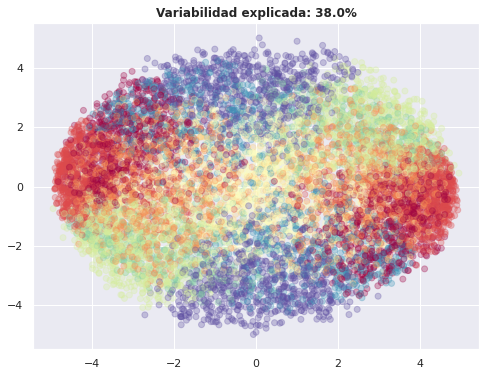

In [81]:
pca = PCA()
Y = pca.fit_transform(EEG_todo_scaled.transpose())

#plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap = plt.cm.Spectral)

#fig = plt.figure(figsize=(32,16))
#ax = fig.add_subplot(251, projection='3d')
plt.scatter(Y[:, 0], Y[:, 1], 
            c=labels_gfp_k_9, 
            cmap = plt.cm.Spectral, alpha = 0.3)
#ax.scatter(Y[:, 1], Y[:, 2], Y[:, 0], c=y, cmap = plt.cm.Spectral)
#ax.view_init(4, -72);

print('PCA')
print('Varianza explicada por componente:',pca.explained_variance_)
explained_variance_ratio_ = pca.explained_variance_ / np.sum(pca.explained_variance_)
explained_variance_ratio_

plt.title("Variabilidad explicada: "+ str(round((explained_variance_ratio_[0] + explained_variance_ratio_[1]),2)*100)+'%',fontweight='bold')